**Topic Modelling (Using LDA and LDAMallet) : Unsupervised**

Topic modeling is an unsupervised machine learning algorithm used for efficient processing of large collections of data, inturn applied for classification, clustering or summarization tasks. In this project LDA and LDAMallet have been used for topic extraction. LDA is a generative probabilistic model, specifically a three-level hierarchical Bayesian model, used for a collection of discrete data (such as a text corpora). Dirichlet distributions allow for probability distribution sampling over a probability simplex in which all the numbers add up to 1, and these numbers represent probabilities over K distinct categories. LDAMallet is a sampling based implementation of LDA.

In [ ]:
#Mounting gdrive to gain access to the dataset
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install pyLDAvis

**Libraries** - Gensim is used for modelling of LDA algorithm as it also provides the wrapper for LDAMallet and hence implementation of both can be done and performances can be compared. Other libraries are used for data preprocessing, visualization, etc.

In [ ]:
#Importing necessary libraries
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import numpy as np
import nltk
nltk.download('wordnet')
import pandas as pd
import json
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Data** - The dataset used for this implementation is the cranfield dataset. It contains 1400 abstracts of aerodynamics journal articles from the
collection of academic papers of the college and is available for public use.

In [ ]:
#importing data
data = pd.read_json('/content/gdrive/My Drive/cran_d.json')
data

id  ...                                              title
0        1  ...  experimental investigation of the aerodynamics...
1        2  ...  simple shear flow past a flat plate in an inco...
2        3  ...  the boundary layer in simple shear flow past a...
3        4  ...  approximate solutions of the incompressible la...
4        5  ...  one-dimensional transient heat conduction into...
...    ...  ...                                                ...
1395  1396  ...  shear buckling of clamped and simply-supported...
1396  1397  ...  critical shear stress of an infinitely long si...
1397  1398  ...  stability of rectangular plates under shear an...
1398  1399  ...  buckling of transverse stiffened plates under ...
1399  1400  ...  the buckling shear stress of simply-supported ...

[1400 rows x 5 columns]

In [ ]:
data.drop(['author', 'bibliography','title'], axis = 1)

id                                               body
0        1  experimental investigation of the aerodynamics...
1        2  simple shear flow past a flat plate in an inco...
2        3  the boundary layer in simple shear flow past a...
3        4  approximate solutions of the incompressible la...
4        5  one-dimensional transient heat conduction into...
...    ...                                                ...
1395  1396  shear buckling of clamped and simply-supported...
1396  1397  critical shear stress of an infinitely long si...
1397  1398  stability of rectangular plates under shear an...
1398  1399  buckling of transverse stiffened plates under ...
1399  1400  the buckling shear stress of simply-supported ...

[1400 rows x 2 columns]

**Data Preprocessing:**  - The preprocessing steps invlove cleaning the text data off the stopwords, punctuation, tokenized, lemmatized and stemmed

In [ ]:
#Data Preprocessing
stemmer = SnowballStemmer(language='english')
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [ ]:
processed_data = data['body'].map(preprocess)
processed_data

0       [experiment, investig, aerodynam, wing, slipst...
1       [simpl, shear, flow, past, flat, plate, incomp...
2       [boundari, layer, simpl, shear, flow, past, fl...
3       [approxim, solut, incompress, laminar, boundar...
4       [dimension, transient, heat, conduct, doubl, l...
                              ...                        
1395    [shear, buckl, clamp, simpli, support, infinit...
1396    [critic, shear, stress, infinit, long, simpli,...
1397    [stabil, rectangular, plat, shear, bend, forc,...
1398    [buckl, transvers, stiffen, plat, shear, paper...
1399    [buckl, shear, stress, simpli, support, infini...
Name: body, Length: 1400, dtype: object

**Creation of Dictionary and the corpus for the LDA model**

In [ ]:
#Creating dictionary and the word corpus
dictionary = corpora.Dictionary(processed_data)
corpus = [dictionary.doc2bow(text) for text in processed_data]

corpus_1399 = corpus[1399]
for i in range(len(corpus_1399)):
    print("Word {} (\"{}\") appears {} time.".format(corpus_1399[i][0], 
                                               dictionary[corpus_1399[i][0]], 
                                               corpus_1399[i][1]))

Word 14 ("effect") appears 1 time.
Word 26 ("investig") appears 1 time.
Word 35 ("ratio") appears 1 time.
Word 47 ("support") appears 2 time.
Word 48 ("theoret") appears 1 time.
Word 67 ("flat") appears 1 time.
Word 84 ("plate") appears 1 time.
Word 92 ("shear") appears 3 time.
Word 100 ("treat") appears 1 time.
Word 119 ("uniform") appears 1 time.
Word 184 ("number") appears 1 time.
Word 194 ("size") appears 1 time.
Word 195 ("space") appears 2 time.
Word 230 ("rang") appears 1 time.
Word 241 ("complet") appears 1 time.
Word 250 ("extens") appears 1 time.
Word 274 ("transvers") appears 2 time.
Word 338 ("calcul") appears 1 time.
Word 355 ("stress") appears 2 time.
Word 366 ("bend") appears 1 time.
Word 377 ("elast") appears 1 time.
Word 387 ("form") appears 1 time.
Word 417 ("panel") appears 2 time.
Word 437 ("torsion") appears 1 time.
Word 445 ("buckl") appears 3 time.
Word 471 ("report") appears 1 time.
Word 541 ("infinit") appears 2 time.
Word 670 ("long") appears 3 time.
Word 680 

In [ ]:
import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dict.gensim')

**Model Building and displaying the topics identified by the model** 

In [ ]:
#with number of topics chosen randomly as 10 and the number of passes 10
NUM_TOPICS = 10
ldam10p10 = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=10)
ldam10p10.save('model10pass10.gensim')
topics = ldam10p10.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.041*"flow" + 0.031*"boundari" + 0.030*"layer" + 0.013*"number"')
(1, '0.023*"buckl" + 0.022*"stress" + 0.016*"shell" + 0.016*"cylind"')
(2, '0.018*"shock" + 0.015*"flow" + 0.015*"wave" + 0.010*"function"')
(3, '0.029*"heat" + 0.027*"flow" + 0.019*"transfer" + 0.018*"layer"')
(4, '0.022*"flow" + 0.018*"solut" + 0.018*"method" + 0.017*"equat"')
(5, '0.030*"boundari" + 0.030*"layer" + 0.016*"wall" + 0.015*"separ"')
(6, '0.041*"pressur" + 0.028*"nozzl" + 0.018*"number" + 0.017*"flow"')
(7, '0.025*"creep" + 0.021*"column" + 0.014*"time" + 0.013*"buckl"')
(8, '0.050*"wing" + 0.029*"bodi" + 0.023*"theori" + 0.023*"flutter"')
(9, '0.030*"number" + 0.024*"mach" + 0.020*"angl" + 0.020*"pressur"')


In [ ]:
#with number of topics chosen randomly as 10 and the number of passes 15
NUM_TOPICS = 10
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model10pass15.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.034*"number" + 0.027*"pressur" + 0.024*"mach" + 0.018*"effect"')
(1, '0.024*"flow" + 0.022*"solut" + 0.018*"method" + 0.015*"equat"')
(2, '0.020*"solut" + 0.019*"equat" + 0.018*"flow" + 0.015*"method"')
(3, '0.026*"buckl" + 0.023*"stress" + 0.022*"shell" + 0.019*"load"')
(4, '0.021*"panel" + 0.019*"plate" + 0.018*"tube" + 0.018*"edg"')
(5, '0.047*"shock" + 0.033*"flow" + 0.029*"wave" + 0.015*"number"')
(6, '0.018*"heat" + 0.015*"problem" + 0.013*"method" + 0.012*"equilibrium"')
(7, '0.054*"wing" + 0.025*"lift" + 0.022*"bodi" + 0.016*"angl"')
(8, '0.027*"flow" + 0.024*"field" + 0.016*"fluid" + 0.015*"magnet"')
(9, '0.042*"layer" + 0.039*"boundari" + 0.032*"flow" + 0.017*"transfer"')


**Performance Evaluation of the Model**

Perplexity is the measure of how well a model predicts a sample. A lower perplexity indicates that the data is more likely. When the number of topics increase, the perplexity of the model will decrease.The coherence score assesses the quality of the learned topics. The higher the coherence score the better the model performance is.

In [ ]:
#Computing Perplexity
print('\nPerplexity: ', ldamodel.log_perplexity(corpus))

#Computing Coherence Score
coherence_ldamodel = CoherenceModel(model=ldamodel, texts=processed_data, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_ldamodel.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.602916951211366

Coherence Score:  0.4072992048673168


In [ ]:
!pip install pandas=='1.2.0'

**Visualization of the model performance**

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.009526 -0.085383       1        1  19.028061
0     -0.164734  0.012584       2        1  17.736659
7     -0.168676  0.027950       3        1  11.476597
5     -0.037881 -0.048035       4        1  10.843129
3      0.057888  0.169972       5        1  10.706810
1      0.082029 -0.072421       6        1   8.472199
6      0.103447 -0.011478       7        1   7.738660
8      0.053365 -0.077886       8        1   5.400092
2      0.031057 -0.050422       9        1   5.153742
4      0.053032  0.135119      10        1   3.444051, topic_info=         Term         Freq        Total Category  logprob  loglift
52       wing   844.000000   844.000000  Default  30.0000  30.0000
93      shock   727.000000   727.000000  Default  29.0000  29.0000
27      layer  1141.000000  1141.000000  Default  28.0000  28.0000
20       flow  2019.000000  2019.000000  Default  27.0000  27.0000
445     buckl   337.000000   337.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
113    obtain    21.936842   623.411971  Topic10  -5.2135   0.0215
209    turbul    20.897774   356.235776  Topic10  -5.2620   0.5326
87    present    21.466259   676.479956  Topic10  -5.2352  -0.0819
5    boundari    21.595244  1188.096222  Topic10  -5.2292  -0.6391
152    method    21.097839   862.588683  Topic10  -5.2525  -0.3422

[743 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1155      2  0.046376    ablat
1155      7  0.417382    ablat
1155      9  0.486946    ablat
1155     10  0.046376    ablat
1026      4  0.292755   acoust
...     ...       ...      ...
52        7  0.001184     wing
52        9  0.008286     wing
2942      2  0.898839  wingtip
3187      9  0.901446   wrinkl
2571      7  0.833124     york

[2378 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 1, 8, 6, 4, 2, 7, 9, 3, 5])

In [ ]:
NUM_TOPICS = 12
ldamodel1 = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel1.save('model12.gensim')
topics = ldamodel1.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.044*"flow" + 0.034*"solut" + 0.026*"equat" + 0.023*"boundari"')
(1, '0.027*"problem" + 0.019*"method" + 0.017*"solut" + 0.017*"equat"')
(2, '0.029*"buckl" + 0.027*"shell" + 0.026*"stress" + 0.022*"cylind"')
(3, '0.036*"boundari" + 0.034*"wall" + 0.033*"layer" + 0.030*"inject"')
(4, '0.044*"panel" + 0.032*"flutter" + 0.027*"bodi" + 0.016*"wing"')
(5, '0.026*"aircraft" + 0.021*"structur" + 0.018*"tube" + 0.016*"test"')
(6, '0.042*"number" + 0.040*"pressur" + 0.034*"mach" + 0.021*"shock"')
(7, '0.034*"wing" + 0.018*"flow" + 0.017*"method" + 0.014*"lift"')
(8, '0.030*"flow" + 0.028*"layer" + 0.025*"boundari" + 0.021*"number"')
(9, '0.021*"field" + 0.016*"heat" + 0.016*"effect" + 0.016*"flow"')
(10, '0.027*"bodi" + 0.018*"lift" + 0.018*"angl" + 0.015*"drag"')
(11, '0.047*"heat" + 0.031*"temperatur" + 0.019*"transfer" + 0.013*"atmospher"')


In [ ]:
#Computing Perplexity
print('\nPerplexity: ', ldamodel1.log_perplexity(corpus))

# Computing Coherence Score
coherence_ldamodel1 = CoherenceModel(model=ldamodel1, texts=processed_data, dictionary=dictionary, coherence='c_v')
coherence_lda1 = coherence_ldamodel1.get_coherence()
print('\nCoherence Score: ', coherence_lda1)


Perplexity:  -6.6130116747613155

Coherence Score:  0.41073934129918954


**LDA(BoW) number of topics = 12**

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel1, corpus, dictionary)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:302: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  token_table['Freq'] = token_table['Freq'].round()


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.022945 -0.074841       1        1  18.424864
0     -0.141543  0.026722       2        1  13.955760
6      0.135763 -0.050495       3        1  11.060740
7      0.034252  0.077100       4        1  10.883564
10     0.137391  0.030467       5        1   9.550961
2     -0.021776  0.175072       6        1   9.033715
11    -0.080844 -0.053879       7        1   6.602134
9     -0.072131 -0.090198       8        1   5.512485
1     -0.085404  0.106389       9        1   5.356596
4      0.030904  0.062654      10        1   3.449124
5      0.192018 -0.066823      11        1   3.291170
3     -0.105687 -0.142167      12        1   2.878886, topic_info=         Term         Freq        Total Category  logprob  loglift
27      layer  1122.000000  1122.000000  Default  30.0000  30.0000
5    boundari  1178.000000  1178.000000  Default  29.0000  29.0000
126      heat   811.000000   811.000000  Default  28.0000  28.0000
52       wing   817.000000   817.000000  Default  27.0000  27.0000
55       bodi   818.000000   818.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
105      wave    22.562291   472.109278  Topic12  -5.0062   0.5068
155     point    20.791309   363.905515  Topic12  -5.0879   0.6854
138      type    17.257641   250.243323  Topic12  -5.2742   0.8736
35      ratio    17.922771   594.430209  Topic12  -5.2364   0.0462
304   stagnat    16.575098   248.329803  Topic12  -5.3145   0.8409

[861 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1155      1  0.021539    ablat
1155      7  0.969263    ablat
358       1  0.212171  ackeret
358      12  0.636514  ackeret
1026      8  0.448423   acoust
...     ...       ...      ...
52       10  0.077098     wing
52       11  0.051399     wing
52       12  0.002448     wing
2942      8  0.788433  wingtip
3187      4  0.909639   wrinkl

[2810 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 1, 7, 8, 11, 3, 12, 10, 2, 5, 6, 4])

**LDA(BoW) number of topics = 14**

In [ ]:
NUM_TOPICS = 14
ldamodel2 = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel2.save('model14.gensim')
topics = ldamodel2.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.025*"atmospher" + 0.024*"satellit" + 0.022*"densiti" + 0.020*"orbit"')
(1, '0.025*"buckl" + 0.022*"stress" + 0.021*"load" + 0.021*"shell"')
(2, '0.034*"number" + 0.029*"layer" + 0.027*"heat" + 0.026*"transfer"')
(3, '0.031*"flow" + 0.022*"veloc" + 0.013*"equat" + 0.013*"wave"')
(4, '0.038*"flow" + 0.027*"wing" + 0.020*"edg" + 0.019*"airfoil"')
(5, '0.040*"angl" + 0.025*"attack" + 0.019*"lift" + 0.018*"drag"')
(6, '0.058*"bodi" + 0.026*"flow" + 0.024*"theori" + 0.013*"method"')
(7, '0.045*"wing" + 0.018*"flutter" + 0.018*"effect" + 0.016*"lift"')
(8, '0.032*"flow" + 0.024*"equilibrium" + 0.018*"dissoci" + 0.014*"shock"')
(9, '0.033*"pressur" + 0.021*"flow" + 0.020*"number" + 0.019*"nozzl"')
(10, '0.041*"shock" + 0.023*"flow" + 0.021*"wave" + 0.019*"pressur"')
(11, '0.044*"heat" + 0.038*"temperatur" + 0.016*"thermal" + 0.012*"surfac"')
(12, '0.023*"resist" + 0.018*"water" + 0.015*"nois" + 0.012*"vessel"')
(13, '0.030*"boundari" + 0.028*"solut" + 0.028*"flow" + 0.025*"layer"')


In [ ]:
#Computing Perplexity
print('\nPerplexity: ', ldamodel2.log_perplexity(corpus))

# Computing Coherence Score
coherence_ldamodel2 = CoherenceModel(model=ldamodel2, texts=processed_data, dictionary=dictionary, coherence='c_v')
coherence_lda2 = coherence_ldamodel2.get_coherence()
print('\nCoherence Score: ', coherence_lda2)


Perplexity:  -6.59918293321448

Coherence Score:  0.4300299054337971


In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel2, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13     0.017548  0.151774       1        1  14.543834
1     -0.039785  0.046126       2        1  11.619776
2      0.105084  0.042472       3        1  10.570927
7      0.050903 -0.125875       4        1   9.724028
3      0.000694  0.127664       5        1   9.334366
9      0.086476 -0.042801       6        1   9.116689
6      0.057273 -0.007626       7        1   7.885069
10     0.119718 -0.003742       8        1   7.267751
5      0.054927 -0.178776       9        1   5.255473
11    -0.072659  0.020729      10        1   4.911718
8     -0.048199  0.108231      11        1   3.918004
4      0.047578 -0.020197      12        1   3.473078
0     -0.179599 -0.023283      13        1   1.455861
12    -0.199959 -0.094696      14        1   0.923425, topic_info=        Term         Freq        Total Category  logprob  loglift
52      wing   812.000000   812.000000  Default  30.0000  30.0000
126     heat   815.000000   815.000000  Default  29.0000  29.0000
55      bodi   849.000000   849.000000  Default  28.0000  28.0000
20      flow  2024.000000  2024.000000  Default  27.0000  27.0000
93     shock   727.000000   727.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
135     time     5.651921   234.598010  Topic14  -5.2534   0.9590
236     valu     5.868704   482.873481  Topic14  -5.2157   0.2747
134   surfac     5.881563   673.903128  Topic14  -5.2135  -0.0564
32   problem     5.810935   580.094573  Topic14  -5.2256   0.0814
113   obtain     5.655213   626.715417  Topic14  -5.2528  -0.0231

[1006 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1155      6  0.022931    ablat
1155     10  0.963084    ablat
1734      5  0.122881  absorpt
1734     10  0.122881  absorpt
1734     13  0.614405  absorpt
...     ...       ...      ...
1881      4  0.115174     wood
1881     10  0.115174     wood
1881     12  0.691043     wood
3187      2  0.924564   wrinkl
2351      7  0.675877     zoom

[3283 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 2, 3, 8, 4, 10, 7, 11, 6, 12, 9, 5, 1, 13])

**LDA(BoW) number of topics = 16**

In [ ]:
NUM_TOPICS = 16
ldamodel3 = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel3.save('model16.gensim')
topics = ldamodel3.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.046*"flow" + 0.023*"solut" + 0.021*"boundari" + 0.019*"layer"')
(1, '0.051*"heat" + 0.034*"transfer" + 0.021*"layer" + 0.019*"temperatur"')
(2, '0.014*"orbit" + 0.011*"problem" + 0.010*"smoke" + 0.008*"effect"')
(3, '0.041*"shock" + 0.023*"flow" + 0.019*"bodi" + 0.018*"wave"')
(4, '0.057*"wing" + 0.019*"lift" + 0.015*"edg" + 0.014*"number"')
(5, '0.031*"layer" + 0.030*"boundari" + 0.025*"inject" + 0.018*"flow"')
(6, '0.032*"layer" + 0.029*"boundari" + 0.029*"number" + 0.028*"turbul"')
(7, '0.022*"blade" + 0.020*"flow" + 0.019*"wave" + 0.018*"compressor"')
(8, '0.019*"lift" + 0.016*"test" + 0.015*"mach" + 0.011*"result"')
(9, '0.020*"deriv" + 0.017*"forc" + 0.016*"atmospher" + 0.016*"stabil"')
(10, '0.057*"pressur" + 0.032*"base" + 0.030*"nozzl" + 0.024*"static"')
(11, '0.023*"panel" + 0.021*"stress" + 0.018*"structur" + 0.017*"flutter"')
(12, '0.042*"pressur" + 0.033*"angl" + 0.027*"number" + 0.024*"mach"')
(13, '0.032*"shell" + 0.026*"buckl" + 0.024*"load" + 0.020*"equat"')
(14

In [ ]:
#Computing Perplexity
print('\nPerplexity: ', ldamodel3.log_perplexity(corpus))

# Computing Coherence Score
coherence_ldamodel3 = CoherenceModel(model=ldamodel3, texts=processed_data, dictionary=dictionary, coherence='c_v')
coherence_lda3 = coherence_ldamodel3.get_coherence()
print('\nCoherence Score: ', coherence_lda3)


Perplexity:  -6.627846031972598

Coherence Score:  0.40127120524597526


In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel3, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.076204  0.121881       1        1  19.207483
4     -0.081550 -0.068267       2        1  11.401437
6     -0.033687  0.069277       3        1   8.219862
15    -0.070593  0.067299       4        1   7.645153
13     0.209498  0.000045       5        1   7.333185
12    -0.147139  0.006710       6        1   6.975653
11     0.111385 -0.104761       7        1   6.670154
3     -0.009877  0.032685       8        1   5.724224
1      0.032596  0.122992       9        1   5.500979
5      0.008379  0.139702      10        1   4.363793
14     0.056169  0.045094      11        1   3.533532
9     -0.012834 -0.156967      12        1   3.485206
7      0.029518 -0.064148      13        1   3.300718
10    -0.151251 -0.013075      14        1   3.072688
8     -0.108158 -0.067748      15        1   1.923474
2      0.091339 -0.130717      16        1   1.642460, topic_info=         Term         Freq        Total Category  logprob  loglift
52       wing   819.000000   819.000000  Default  30.0000  30.0000
126      heat   795.000000   795.000000  Default  29.0000  29.0000
108   pressur  1369.000000  1369.000000  Default  28.0000  28.0000
27      layer  1126.000000  1126.000000  Default  27.0000  27.0000
5    boundari  1178.000000  1178.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
135      time    10.117496   235.829150  Topic16  -5.2470   0.9601
337    applic     9.989932   267.958460  Topic16  -5.2596   0.8197
59   constant     9.839821   256.678410  Topic16  -5.2748   0.8476
5    boundari    10.391333  1178.904082  Topic16  -5.2203  -0.6224
244   develop     9.773688   315.514533  Topic16  -5.2815   0.6345

[1176 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1155      4  0.947691    ablat
1155     10  0.023114    ablat
1155     15  0.023114    ablat
1804      1  0.182824  accumul
1804     16  0.731296  accumul
...     ...       ...      ...
514      13  0.011149     zero
514      14  0.005575     zero
514      15  0.011149     zero
514      16  0.005575     zero
2351      5  0.679173     zoom

[4033 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 7, 16, 14, 13, 12, 4, 2, 6, 15, 10, 8, 11, 9, 3])

**LDA(BoW) number of topics = 18**

In [ ]:
NUM_TOPICS = 18
ldamodel4 = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel4.save('model18.gensim')
topics = ldamodel4.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.030*"flow" + 0.028*"shock" + 0.027*"bodi" + 0.022*"pressur"')
(1, '0.076*"wing" + 0.039*"lift" + 0.022*"ratio" + 0.020*"edg"')
(2, '0.034*"creep" + 0.028*"column" + 0.025*"time" + 0.018*"equilibrium"')
(3, '0.026*"propel" + 0.020*"effect" + 0.018*"wing" + 0.017*"flap"')
(4, '0.045*"rough" + 0.032*"transit" + 0.026*"flow" + 0.023*"number"')
(5, '0.052*"pressur" + 0.031*"nozzl" + 0.030*"number" + 0.027*"mach"')
(6, '0.028*"equat" + 0.023*"method" + 0.021*"solut" + 0.019*"function"')
(7, '0.050*"layer" + 0.049*"boundari" + 0.024*"flow" + 0.021*"laminar"')
(8, '0.033*"flow" + 0.024*"number" + 0.015*"mach" + 0.015*"pressur"')
(9, '0.024*"dissoci" + 0.023*"wave" + 0.018*"reaction" + 0.018*"equilibrium"')
(10, '0.037*"design" + 0.021*"tube" + 0.021*"blade" + 0.020*"test"')
(11, '0.029*"pressur" + 0.022*"measur" + 0.021*"number" + 0.015*"effect"')
(12, '0.024*"shell" + 0.021*"stress" + 0.020*"load" + 0.018*"buckl"')
(13, '0.025*"deriv" + 0.022*"flutter" + 0.021*"test" + 0.015*"bodi"')
(

In [ ]:
#Computing Perplexity
print('\nPerplexity: ', ldamodel4.log_perplexity(corpus))

# Computing Coherence Score
coherence_ldamodel4 = CoherenceModel(model=ldamodel4, texts=processed_data, dictionary=dictionary, coherence='c_v')
coherence_lda4 = coherence_ldamodel4.get_coherence()
print('\nCoherence Score: ', coherence_lda4)


Perplexity:  -6.631252779445382

Coherence Score:  0.4130021164071263


In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel4, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.107616  0.115302       1        1  14.987096
8      0.001929  0.089154       2        1  13.801231
0      0.011738  0.109128       3        1  11.469008
12     0.093188 -0.131531       4        1   9.977570
6      0.131128  0.020752       5        1   9.873509
1     -0.163311  0.047438       6        1   6.765925
5     -0.166824  0.051558       7        1   4.978649
17     0.042684 -0.032806       8        1   3.856534
13    -0.064995 -0.012457       9        1   3.445341
16     0.109793  0.063458      10        1   3.142601
10    -0.102735 -0.015362      11        1   2.900854
3     -0.147872 -0.134130      12        1   2.832928
9      0.121123  0.033304      13        1   2.175535
15    -0.006719 -0.171076      14        1   2.167862
11    -0.052376  0.023426      15        1   2.107864
2      0.115550 -0.168732      16        1   2.089201
4      0.003144  0.096570      17        1   2.080616
14    -0.033059  0.016003      18        1   1.347676, topic_info=        Term         Freq        Total Category  logprob  loglift
93     shock   723.000000   723.000000  Default  30.0000  30.0000
105     wave   477.000000   477.000000  Default  29.0000  29.0000
52      wing   836.000000   836.000000  Default  28.0000  28.0000
20      flow  1992.000000  1992.000000  Default  27.0000  27.0000
27     layer  1155.000000  1155.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
387     form    10.553370   301.136979  Topic18  -5.0070   0.9557
135     time     9.408382   237.167470  Topic18  -5.1218   1.0796
443   author     8.217238   124.605057  Topic18  -5.2572   1.5879
48   theoret     7.891519   301.004753  Topic18  -5.2976   0.6655
113   obtain     7.732006   622.498966  Topic18  -5.3180  -0.0816

[1267 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1155      1  0.110115    ablat
1155      3  0.044046    ablat
1155      8  0.418438    ablat
1155      9  0.418438    ablat
1734      7  0.114063  absorpt
...     ...       ...      ...
1881     12  0.722843     wood
1881     15  0.120474     wood
3187      4  0.813709   wrinkl
3187     14  0.101714   wrinkl
2351     10  0.698205     zoom

[4512 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 9, 1, 13, 7, 2, 6, 18, 14, 17, 11, 4, 10, 16, 12, 3, 5, 15])

we can see that the model performance is getting worse with increase in the number of topics. Based on the coherence score and the tradeoff with the perplexity score, the model with number of topics 10 and 12 perform better than the rest with higher number of topics

**Performing tf-idf instead of bag of words and checking the model performance for the number of topics 10, 12 and 14**

In [ ]:
from gensim import corpora, models
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.053302445840307376),
 (1, 0.08206383857277204),
 (2, 0.048917665629352944),
 (3, 0.06499483304247398),
 (4, 0.0783847211538762),
 (5, 0.028340962543825454),
 (6, 0.04495784529265081),
 (7, 0.07385116512341265),
 (8, 0.08119993508064181),
 (9, 0.0630256806900624),
 (10, 0.509307940076426),
 (11, 0.04000670522109575),
 (12, 0.1544567313753436),
 (13, 0.03512348375093592),
 (14, 0.04937572128417836),
 (15, 0.09791849493987904),
 (16, 0.1552670353827112),
 (17, 0.09486618233401206),
 (18, 0.055570484690629675),
 (19, 0.07350588940046916),
 (20, 0.01687521477063807),
 (21, 0.048194417622460475),
 (22, 0.049287002591385444),
 (23, 0.22862026072668198),
 (24, 0.05840643038238435),
 (25, 0.12333639554404417),
 (26, 0.03512348375093592),
 (27, 0.03157347976088682),
 (28, 0.2254914465151426),
 (29, 0.050427687185562314),
 (30, 0.050819352648683),
 (31, 0.08250683576792811),
 (32, 0.038005863257038426),
 (33, 0.07482919458418888),
 (34, 0.095596222296088),
 (35, 0.040268032190421986),
 (36

**LDA(TF-IDF) number of topics = 14**

In [ ]:
ldamodel_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=14, id2word=dictionary, passes=15, workers=4)
for idx, topic in ldamodel_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

Topic: 0 Word: 0.032*"wing" + 0.017*"lift" + 0.009*"aspect" + 0.007*"vortex" + 0.007*"flutter" + 0.007*"slender" + 0.006*"delta" + 0.006*"ratio" + 0.006*"interfer" + 0.006*"aerodynam"
Topic: 1 Word: 0.015*"magnet" + 0.009*"field" + 0.008*"heat" + 0.007*"entri" + 0.006*"convect" + 0.006*"conduct" + 0.006*"electr" + 0.005*"channel" + 0.005*"vehicl" + 0.004*"plat"
Topic: 2 Word: 0.007*"solut" + 0.007*"equat" + 0.006*"cylind" + 0.006*"buckl" + 0.006*"shell" + 0.005*"problem" + 0.005*"flow" + 0.005*"load" + 0.005*"stress" + 0.005*"boundari"
Topic: 3 Word: 0.010*"shock" + 0.007*"pressur" + 0.007*"mach" + 0.007*"number" + 0.007*"bodi" + 0.007*"wave" + 0.006*"separ" + 0.005*"layer" + 0.005*"angl" + 0.005*"nozzl"
Topic: 4 Word: 0.002*"interferometr" + 0.002*"rule" + 0.002*"jone" + 0.002*"kelvin" + 0.002*"dome" + 0.002*"boom" + 0.002*"regular" + 0.002*"fold" + 0.002*"status" + 0.002*"plume"
Topic: 5 Word: 0.003*"aeroelast" + 0.003*"squir" + 0.003*"tool" + 0.002*"system" + 0.002*"control" + 0.002

In [ ]:
#Computing Perplexity
print('\nPerplexity: ', ldamodel_tfidf.log_perplexity(corpus))

# Computing Coherence Score
coherence_ldamodel5 = CoherenceModel(model=ldamodel_tfidf, texts=processed_data, dictionary=dictionary, coherence='c_v')
coherence_lda5 = coherence_ldamodel5.get_coherence()
print('\nCoherence Score: ', coherence_lda5)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for


Perplexity:  -7.1209807241799865

Coherence Score:  0.553061539201683


In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel_tfidf, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.228135 -0.062603       1        1  45.467370
3     -0.202159  0.021981       2        1  37.510416
0     -0.067577  0.165762       3        1   6.738754
11    -0.054326 -0.048070       4        1   2.931425
1      0.007684 -0.060768       5        1   1.882754
6     -0.007880 -0.002955       6        1   1.694392
13     0.045162 -0.002797       7        1   0.707729
10     0.064882 -0.003444       8        1   0.618099
8      0.066195 -0.007552       9        1   0.517370
12     0.076920  0.003025      10        1   0.459422
5      0.074328  0.002666      11        1   0.425178
9      0.077656  0.000111      12        1   0.424407
4      0.075193 -0.002607      13        1   0.336535
7      0.072056 -0.002749      14        1   0.286150, topic_info=          Term        Freq       Total Category  logprob  loglift
52        wing  383.000000  383.000000  Default  30.0000  30.0000
126       heat  390.000000  390.000000  Default  29.0000  29.0000
27       layer  529.000000  529.000000  Default  28.0000  28.0000
335   transfer  281.000000  281.000000  Default  27.0000  27.0000
93       shock  530.000000  530.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
3628       wet    0.401145    7.582047  Topic14  -6.7272   2.9172
1270     digit    0.516980   20.962654  Topic14  -6.4735   2.1539
350     proper    0.470269   26.641609  Topic14  -6.5682   1.8195
1295   mangler    0.387131    9.173375  Topic14  -6.7628   2.6911
1742    oxygen    0.382414    8.113069  Topic14  -6.7750   2.8017

[756 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1155      1  0.063008   ablat
1155      2  0.063008   ablat
1155      3  0.189025   ablat
1155      4  0.126017   ablat
1155      7  0.441059   ablat
...     ...       ...     ...
3187      4  0.560501  wrinkl
2351      1  0.193232    zoom
2351      2  0.193232    zoom
2351      3  0.193232    zoom
2351      9  0.193232    zoom

[3006 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 12, 2, 7, 14, 11, 9, 13, 6, 10, 5, 8])

**LDA(TF-IDF) number of topics = 12**

In [ ]:
ldamodel_tfidf1 = gensim.models.LdaMulticore(corpus_tfidf, num_topics=12, id2word=dictionary, passes=15, workers=4)
for idx, topic in ldamodel_tfidf1.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

Topic: 0 Word: 0.019*"creep" + 0.014*"column" + 0.011*"plastic" + 0.010*"buckl" + 0.007*"imperfect" + 0.007*"stress" + 0.007*"strain" + 0.005*"beam" + 0.004*"deform" + 0.004*"fatigu"
Topic: 1 Word: 0.004*"freestream" + 0.002*"annulus" + 0.002*"kernel" + 0.002*"magnus" + 0.002*"stator" + 0.002*"cruciform" + 0.002*"standoff" + 0.002*"mountain" + 0.002*"mesh" + 0.002*"decrement"
Topic: 2 Word: 0.003*"indici" + 0.003*"dyke" + 0.003*"sink" + 0.002*"sublim" + 0.002*"grind" + 0.002*"lubric" + 0.002*"mathieu" + 0.002*"smoke" + 0.002*"sting" + 0.002*"probe"
Topic: 3 Word: 0.007*"entri" + 0.007*"reaction" + 0.006*"slab" + 0.006*"freez" + 0.006*"dissoci" + 0.005*"nonequilibrium" + 0.005*"oscillatori" + 0.004*"atmospher" + 0.004*"composit" + 0.004*"law"
Topic: 4 Word: 0.003*"water" + 0.003*"preston" + 0.003*"hodograph" + 0.002*"imperfect" + 0.002*"adjust" + 0.002*"retrorocket" + 0.002*"deton" + 0.002*"raleigh" + 0.002*"undisturb" + 0.002*"schmidt"
Topic: 5 Word: 0.003*"shed" + 0.002*"eddi" + 0.002

In [ ]:
#Computing Perplexity
print('\nPerplexity: ', ldamodel_tfidf1.log_perplexity(corpus))

# Computing Coherence Score
coherence_ldamodel6 = CoherenceModel(model=ldamodel_tfidf1, texts=processed_data, dictionary=dictionary, coherence='c_v')
coherence_lda6 = coherence_ldamodel6.get_coherence()
print('\nCoherence Score: ', coherence_lda6)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for


Perplexity:  -7.056458634714943

Coherence Score:  0.5941873919958373


In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel_tfidf1, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.292806  0.000414       1        1  89.636808
10    -0.014861 -0.109791       2        1   2.013990
3     -0.000206  0.053365       3        1   1.694730
0     -0.032581 -0.037054       4        1   1.456850
6     -0.037426  0.029189       5        1   1.225205
9     -0.027015  0.020815       6        1   0.891716
7     -0.032645  0.000035       7        1   0.800613
5     -0.035552  0.009265       8        1   0.601296
2     -0.031699  0.010770       9        1   0.566322
4     -0.028397  0.008940      10        1   0.423595
1     -0.027130  0.007202      11        1   0.360445
11    -0.025295  0.006850      12        1   0.328430, topic_info=          Term        Freq       Total Category  logprob  loglift
559     cylind  374.000000  374.000000  Default  30.0000  30.0000
386    flutter  209.000000  209.000000  Default  29.0000  29.0000
1283     shell  210.000000  210.000000  Default  28.0000  28.0000
355     stress  221.000000  221.000000  Default  27.0000  27.0000
29        load  288.000000  288.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
1983  downwash    0.550098   11.904138  Topic12  -6.5493   2.6441
692     spring    0.589889   27.342753  Topic12  -6.4794   1.8823
1028      nois    0.592515   29.018846  Topic12  -6.4750   1.8273
1360     flame    0.495800    8.278701  Topic12  -6.6532   2.9033
776    quantit    0.477092   10.020752  Topic12  -6.6916   2.6739

[567 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1026      1  0.791072    acoust
1026      2  0.079107    acoust
1026      5  0.105476    acoust
2519      1  0.252544  adequaci
1777      1  0.174207    adjust
...     ...       ...       ...
441       1  0.103168      zone
441       3  0.103168      zone
441       4  0.206336      zone
441       5  0.309504      zone
441       8  0.103168      zone

[1357 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 11, 4, 1, 7, 10, 8, 6, 3, 5, 2, 12])

**LDA(TF-IDF) number of topics = 10**

In [ ]:
ldamodel_tfidf2 = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=15, workers=4)
for idx, topic in ldamodel_tfidf2.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

Topic: 0 Word: 0.015*"panel" + 0.006*"flutter" + 0.005*"slab" + 0.004*"composit" + 0.003*"ablat" + 0.003*"transient" + 0.003*"charg" + 0.003*"heat" + 0.003*"cantilev" + 0.002*"fatigu"
Topic: 1 Word: 0.003*"modul" + 0.002*"corridor" + 0.002*"rhombic" + 0.002*"descend" + 0.002*"belotserkovskii" + 0.002*"hodograph" + 0.002*"erfc" + 0.002*"singular" + 0.002*"airforc" + 0.001*"list"
Topic: 2 Word: 0.006*"structur" + 0.006*"fatigu" + 0.004*"rough" + 0.004*"random" + 0.003*"nois" + 0.003*"life" + 0.003*"trip" + 0.003*"modulus" + 0.003*"matrix" + 0.003*"element"
Topic: 3 Word: 0.006*"impel" + 0.004*"blockag" + 0.004*"shroud" + 0.002*"blade" + 0.002*"analogu" + 0.002*"pump" + 0.002*"perfor" + 0.002*"nonvisc" + 0.002*"centrifug" + 0.002*"eros"
Topic: 4 Word: 0.002*"swirl" + 0.002*"squir" + 0.002*"missil" + 0.002*"legendr" + 0.002*"disloc" + 0.002*"modul" + 0.002*"background" + 0.002*"deceler" + 0.002*"honeycomb" + 0.001*"cancel"
Topic: 5 Word: 0.003*"spike" + 0.002*"matrix" + 0.002*"tailplan" + 

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [ ]:
#Computing Perplexity
print('\nPerplexity: ', ldamodel_tfidf2.log_perplexity(corpus))

# Computing Coherence Score
coherence_ldamodel7 = CoherenceModel(model=ldamodel_tfidf2, texts=processed_data, dictionary=dictionary, coherence='c_v')
coherence_lda7 = coherence_ldamodel7.get_coherence()
print('\nCoherence Score: ', coherence_lda7)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for


Perplexity:  -7.106324592104971

Coherence Score:  0.5405597207239979


In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel_tfidf2, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.204221  0.016010       1        1  55.259148
9      0.178409 -0.026983       2        1  37.147988
8      0.007706  0.062743       3        1   2.015953
6     -0.032567 -0.075596       4        1   1.737205
0     -0.019144  0.001921       5        1   1.329707
2     -0.057053  0.013884       6        1   0.904140
3     -0.073832  0.002447       7        1   0.451636
1     -0.070712  0.002297       8        1   0.416934
4     -0.072036  0.002283       9        1   0.396584
5     -0.064992  0.000994      10        1   0.340706, topic_info=          Term        Freq       Total Category  logprob  loglift
52        wing  405.000000  405.000000  Default  30.0000  30.0000
386    flutter  193.000000  193.000000  Default  29.0000  29.0000
331   structur  140.000000  140.000000  Default  28.0000  28.0000
126       heat  484.000000  484.000000  Default  27.0000  27.0000
28        lift  265.000000  265.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
1545       emb    0.387898    8.721210  Topic10  -6.9353   2.5691
399     invers    0.460075   25.301290  Topic10  -6.7647   1.6747
808      coupl    0.441570   32.377779  Topic10  -6.8057   1.3870
1034  interior    0.362851    7.722214  Topic10  -7.0021   2.6240
900     member    0.364428   13.741642  Topic10  -6.9977   2.0520

[543 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1155      1  0.104233   ablat
1155      2  0.208466   ablat
1155      3  0.208466   ablat
1155      4  0.260583   ablat
1155      5  0.260583   ablat
...     ...       ...     ...
3187      2  0.136717  wrinkl
3187      5  0.410150  wrinkl
2387      1  0.372146   young
2387      2  0.186073   young
2387      3  0.186073   young

[1665 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 10, 9, 7, 1, 3, 4, 2, 5, 6])

With the tf-idf LDA model, based on the coherence score and the map we can intrepret that the model with the number of topics 12 performs better than the rest with good coherence score and the non-overlapping big circles.

**Implementation using LDAMallet**

In [ ]:
#environment setup for executing the Mallet LDA
import os       
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"    
  !java -version       #check java version
install_java()

openjdk version "11.0.11" 2021-04-20
OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04)
OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)


In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

**Number of Topics: 10**

In [ ]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=dictionary)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [ ]:
print(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=processed_data, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0, [('solut', 0.06863379143088116), ('equat', 0.06281325788197252), ('method', 0.04001616814874697), ('problem', 0.03589329021827001), ('function', 0.02667744543249798), ('give', 0.023524656426839128), ('numer', 0.021503637833468068), ('approxim', 0.021422797089733225), ('form', 0.020695230396119646), ('obtain', 0.018997574777687955)]), (1, [('flow', 0.1604254951137248), ('veloc', 0.05007351033468823), ('case', 0.03571737438381043), ('dimension', 0.03139323704920868), ('constant', 0.022917927873389258), ('fluid', 0.02257199688662112), ('approxim', 0.0215342039263167), ('stream', 0.01928565251232379), ('region', 0.017210066591714954), ('viscous', 0.016950618351638847)]), (2, [('boundari', 0.09844980115250386), ('layer', 0.09374239103968833), ('heat', 0.06841977112247383), ('temperatur', 0.05105105105105105), ('transfer', 0.039769499228958685), ('surfac', 0.036198360522684846), ('laminar', 0.03441279116954793), ('plate', 0.03197792386981576), ('wall', 0.030598165733300868), ('turbul', 

**Number of Topics: 12**

In [ ]:
ldamallet1 = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=12, id2word=dictionary)
print(ldamallet1.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet1 = CoherenceModel(model=ldamallet1, texts=processed_data, dictionary=dictionary, coherence='c_v')
coherence_ldamallet1 = coherence_model_ldamallet1.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet1)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


[(5, [('wing', 0.08842460694312546), ('edg', 0.03914740951777989), ('lead', 0.03292181069958848), ('calcul', 0.032288698955365625), ('lift', 0.03218318033132848), ('forc', 0.02690724912947135), ('distribut', 0.02321409728817136), ('section', 0.022053392423762794), ('deriv', 0.019309908198797087), ('airfoil', 0.01888783370264852)]), (8, [('theori', 0.09754479097544791), ('result', 0.08714886087148861), ('experiment', 0.04810882548108825), ('present', 0.03395266533952666), ('obtain', 0.033731475337314756), ('data', 0.02886529528865295), ('compar', 0.028201725282017254), ('theoret', 0.027648750276487503), ('predict', 0.025436850254368502), ('analysi', 0.0247732802477328)]), (1, [('method', 0.09088117899907891), ('problem', 0.05854057926517245), ('applic', 0.027223416231706068), ('give', 0.026609354211442022), ('calcul', 0.02435779347047385), ('general', 0.021389827039197624), ('relat', 0.020161702998669533), ('present', 0.01934295363831747), ('paper', 0.0184218606079214), ('simpl', 0.0179

**Number of Topics: 14**

In [ ]:
ldamallet2 = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=14, id2word=dictionary)
print(ldamallet2.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet2 = CoherenceModel(model=ldamallet2, texts=processed_data, dictionary=dictionary, coherence='c_v')
coherence_ldamallet2 = coherence_model_ldamallet2.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet2)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


[(9, [('number', 0.0986267166042447), ('measur', 0.04857564408126206), ('mach', 0.04675973215299058), ('reynold', 0.04346839178299852), ('test', 0.037112700034048346), ('data', 0.03688571104301441), ('tunnel', 0.03529678810577687), ('effect', 0.03438883214164113), ('transit', 0.03132448076268301), ('model', 0.026557711950970377)]), (6, [('solut', 0.09233278955954323), ('equat', 0.08450244698205546), ('method', 0.06035889070146819), ('approxim', 0.03871669385535617), ('case', 0.034692767808591624), ('numer', 0.028928765633496466), ('obtain', 0.027079934747145186), ('linear', 0.024796084828711255), ('integr', 0.02457857531266993), ('fluid', 0.02142468733007069)]), (1, [('problem', 0.07283707172787775), ('general', 0.03438501355681538), ('develop', 0.029455262509243282), ('give', 0.027976337194971654), ('paper', 0.027606605866403747), ('applic', 0.02563470544737491), ('simpl', 0.02378604880453537), ('present', 0.023416317475967462), ('work', 0.017130884890313038), ('note', 0.0158984471284

**Number of Topics: 16**

In [ ]:
ldamallet3 = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=16, id2word=dictionary)
print(ldamallet3.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet3 = CoherenceModel(model=ldamallet3, texts=processed_data, dictionary=dictionary, coherence='c_v')
coherence_ldamallet3 = coherence_model_ldamallet3.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet3)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


[(11, [('boundari', 0.15598098419632533), ('layer', 0.14917127071823205), ('laminar', 0.05460619298471026), ('plate', 0.05010921238596942), ('wall', 0.04831042014647308), ('surfac', 0.04342798406784017), ('turbul', 0.0420146473082359), ('flat', 0.03353462675061031), ('skin', 0.026210972632660926), ('gradient', 0.023641269433380446)]), (9, [('wing', 0.11037934668071654), ('edg', 0.04913066385669125), ('lift', 0.04214963119072708), ('lead', 0.04070073761854584), ('section', 0.02792413066385669), ('ratio', 0.025948366701791358), ('forc', 0.022391991570073762), ('aspect', 0.01738672286617492), ('moment', 0.017123287671232876), ('speed', 0.01672813487881981)]), (12, [('load', 0.05075390414647281), ('stress', 0.04711900915455035), ('cylind', 0.04698438341410878), ('buckl', 0.04658050619278406), ('shell', 0.0395799676898223), ('panel', 0.027463651050080775), ('cylindr', 0.022482498653742595), ('axial', 0.02221324717285945), ('circular', 0.021540118470651588), ('compress', 0.021405492730210016

**Number of Topics: 18**

In [ ]:
ldamallet4 = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=18, id2word=dictionary)
print(ldamallet4.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet4 = CoherenceModel(model=ldamallet4, texts=processed_data, dictionary=dictionary, coherence='c_v')
coherence_ldamallet4 = coherence_model_ldamallet4.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet4)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


[(1, [('solut', 0.1210781517398745), ('equat', 0.11081003993154592), ('function', 0.046491728465487735), ('problem', 0.04021677124928694), ('numer', 0.03793496862521392), ('obtain', 0.035082715345122646), ('integr', 0.030519110096976613), ('approxim', 0.028237307472903594), ('form', 0.028237307472903594), ('linear', 0.02524244152880776)]), (12, [('flutter', 0.04093567251461988), ('panel', 0.03508771929824561), ('effect', 0.03061575507395941), ('type', 0.03027175782593739), ('stabil', 0.02958376332989336), ('aerodynam', 0.02786377708978328), ('frequenc', 0.02287581699346405), ('show', 0.02218782249742002), ('valu', 0.021843825249398006), ('oscil', 0.018747850017199863)]), (15, [('give', 0.06450032658393207), ('cylind', 0.02759634225996081), ('case', 0.026779882429784456), ('condit', 0.02612671456564337), ('formula', 0.025473546701502287), ('valu', 0.024167210973220117), ('section', 0.024003919007184845), ('deriv', 0.02155453951665578), ('length', 0.021227955584585238), ('small', 0.02073

**Number of Topics: 20**

In [ ]:
ldamallet5 = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=dictionary)
print(ldamallet5.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet5 = CoherenceModel(model=ldamallet5, texts=processed_data, dictionary=dictionary, coherence='c_v')
coherence_ldamallet5 = coherence_model_ldamallet5.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet5)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


[(17, [('bodi', 0.14059927560092197), ('angl', 0.06717155087257162), ('shape', 0.050049390846229835), ('blunt', 0.04609812314784326), ('nose', 0.04148831083305894), ('attack', 0.037701679288771814), ('cone', 0.030128416200197565), ('distribut', 0.022555153111623313), ('revolut', 0.02074415541652947), ('base', 0.01959170233783339)]), (3, [('theori', 0.14912131035659443), ('result', 0.09605869305579252), ('experiment', 0.07507251322299949), ('theoret', 0.05272137860433373), ('predict', 0.04026616618324518), ('data', 0.04026616618324518), ('compar', 0.038559972700904284), ('agreement', 0.037536256611499744), ('present', 0.03258829551271114), ('comparison', 0.02695785702098618)]), (4, [('problem', 0.05705059203444564), ('present', 0.054000717617509866), ('paper', 0.04413347685683531), ('discuss', 0.04323645496950126), ('general', 0.033189809831359884), ('note', 0.024040186580552566), ('analysi', 0.020810907786149982), ('develop', 0.020631503408683173), ('recent', 0.01847865087908145), ('wo

Based on the coherence value, it is observed that the LDAMallet model with number of topics=10 performs better

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=processed_data, start=2, limit=40, step=2)

**To check which number would be optimal number of topics for LDAMallet**

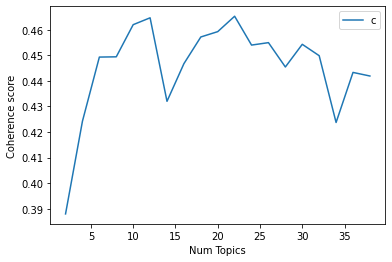

In [ ]:
limit=40; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.388
Num Topics = 4  has Coherence Value of 0.4242
Num Topics = 6  has Coherence Value of 0.4493
Num Topics = 8  has Coherence Value of 0.4494
Num Topics = 10  has Coherence Value of 0.462
Num Topics = 12  has Coherence Value of 0.4646
Num Topics = 14  has Coherence Value of 0.432
Num Topics = 16  has Coherence Value of 0.4467
Num Topics = 18  has Coherence Value of 0.4571
Num Topics = 20  has Coherence Value of 0.4592
Num Topics = 22  has Coherence Value of 0.4653
Num Topics = 24  has Coherence Value of 0.454
Num Topics = 26  has Coherence Value of 0.4549
Num Topics = 28  has Coherence Value of 0.4454
Num Topics = 30  has Coherence Value of 0.4543
Num Topics = 32  has Coherence Value of 0.4498
Num Topics = 34  has Coherence Value of 0.4237
Num Topics = 36  has Coherence Value of 0.4433
Num Topics = 38  has Coherence Value of 0.4419


Displaying the topics which from the optimal model with number of topics=10 and 12

In [ ]:
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.091*"boundari" + 0.087*"layer" + 0.064*"heat" + 0.047*"temperatur" + '
  '0.037*"transfer" + 0.032*"laminar" + 0.029*"plate" + 0.028*"wall" + '
  '0.028*"turbul" + 0.027*"surfac"'),
 (1,
  '0.110*"number" + 0.095*"pressur" + 0.067*"mach" + 0.031*"reynold" + '
  '0.026*"ratio" + 0.026*"base" + 0.026*"increas" + 0.022*"transit" + '
  '0.022*"angl" + 0.022*"separ"'),
 (2,
  '0.043*"cylind" + 0.040*"load" + 0.034*"stress" + 0.033*"buckl" + '
  '0.028*"shell" + 0.020*"circular" + 0.020*"panel" + 0.019*"axial" + '
  '0.018*"compress" + 0.017*"curv"'),
 (3,
  '0.021*"valu" + 0.018*"maximum" + 0.017*"time" + 0.016*"condit" + '
  '0.015*"equilibrium" + 0.015*"veloc" + 0.015*"constant" + 0.015*"variat" + '
  '0.015*"properti" + 0.015*"relat"'),
 (4,
  '0.028*"discuss" + 0.025*"problem" + 0.016*"paper" + 0.014*"general" + '
  '0.014*"develop" + 0.013*"structur" + 0.012*"frequenc" + 0.012*"aircraft" + '
  '0.012*"type" + 0.011*"includ"'),
 (5,
  '0.162*"flow" + 0.064*"shock" + 0.060*"bod

In [ ]:
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.081*"shock" + 0.053*"wave" + 0.022*"effect" + 0.017*"larg" + '
  '0.016*"densiti" + 0.014*"show" + 0.014*"small" + 0.013*"speed" + '
  '0.013*"import" + 0.013*"high"'),
 (1,
  '0.126*"pressur" + 0.039*"valu" + 0.038*"ratio" + 0.032*"free" + '
  '0.030*"stream" + 0.028*"increas" + 0.027*"nozzl" + 0.027*"effect" + '
  '0.019*"investig" + 0.018*"coeffici"'),
 (2,
  '0.033*"problem" + 0.029*"discuss" + 0.027*"present" + 0.020*"paper" + '
  '0.020*"requir" + 0.020*"design" + 0.019*"develop" + 0.015*"work" + '
  '0.015*"general" + 0.014*"possibl"'),
 (3,
  '0.086*"bodi" + 0.068*"theori" + 0.035*"hyperson" + 0.032*"shape" + '
  '0.031*"angl" + 0.028*"blunt" + 0.026*"base" + 0.025*"nose" + '
  '0.024*"predict" + 0.022*"pressur"'),
 (4,
  '0.069*"method" + 0.059*"calcul" + 0.051*"distribut" + 0.038*"superson" + '
  '0.033*"result" + 0.032*"give" + 0.030*"deriv" + 0.028*"section" + '
  '0.025*"dimension" + 0.022*"determin"'),
 (5,
  '0.082*"solut" + 0.075*"equat" + 0.034*"approxim" + 0

**To check the performance of the models(LDA(BoW and TF-IDF) and LDAMallet)on the unseen data**

LDA Model(TF-IDF) with number of topics = 12

In [ ]:
unseendata = 'Aerodynamic interaction between propellers of a distributed-propulsion system in forward flight'
corpust = dictionary.doc2bow(preprocess(unseendata))
for index, score in sorted(ldamodel_tfidf1[corpust], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, ldamodel_tfidf1.print_topic(index, 2)))

Score: 0.7664905786514282	 Topic: 0.006*"layer" + 0.006*"flow"
Score: 0.12934273481369019	 Topic: 0.011*"exhaust" + 0.009*"exit"
Score: 0.010416688397526741	 Topic: 0.007*"entri" + 0.007*"reaction"
Score: 0.010416671633720398	 Topic: 0.009*"boom" + 0.007*"spanwis"
Score: 0.010416668839752674	 Topic: 0.003*"indici" + 0.003*"dyke"
Score: 0.0104166679084301	 Topic: 0.019*"creep" + 0.014*"column"
Score: 0.0104166679084301	 Topic: 0.004*"freestream" + 0.002*"annulus"
Score: 0.0104166679084301	 Topic: 0.003*"water" + 0.003*"preston"
Score: 0.0104166679084301	 Topic: 0.003*"shed" + 0.002*"eddi"
Score: 0.0104166679084301	 Topic: 0.018*"panel" + 0.011*"flutter"
Score: 0.0104166679084301	 Topic: 0.016*"shell" + 0.015*"stiffen"
Score: 0.0104166679084301	 Topic: 0.003*"squir" + 0.003*"attenu"


LDA Model(TF-IDF) with number of topics = 14

In [ ]:
unseen_data = 'Aerodynamic interaction between propellers of a distributed-propulsion system in forward flight'
corpus_t = dictionary.doc2bow(preprocess(unseen_data))
for index, score in sorted(ldamodel_tfidf[corpus_t], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, ldamodel_tfidf.print_topic(index, 2)))

Score: 0.8839283585548401	 Topic: 0.010*"shock" + 0.007*"pressur"


LDA Model(BoW) with number of topics = 12

In [ ]:
unseen_data1 = 'Aerodynamic interaction between propellers of a distributed-propulsion system in forward flight'
corpus_t1 = dictionary.doc2bow(preprocess(unseen_data))
for index, score in sorted(ldamodel1[corpus_t1], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, ldamodel1.print_topic(index, 2)))

Score: 0.8854108452796936	 Topic: 0.026*"aircraft" + 0.021*"structur"
Score: 0.010417982004582882	 Topic: 0.042*"number" + 0.040*"pressur"
Score: 0.010417533107101917	 Topic: 0.034*"wing" + 0.018*"flow"
Score: 0.010417407378554344	 Topic: 0.044*"panel" + 0.032*"flutter"
Score: 0.010417239740490913	 Topic: 0.030*"flow" + 0.028*"layer"
Score: 0.010417178273200989	 Topic: 0.027*"bodi" + 0.018*"lift"
Score: 0.010417119599878788	 Topic: 0.044*"flow" + 0.034*"solut"
Score: 0.010417086072266102	 Topic: 0.047*"heat" + 0.031*"temperatur"
Score: 0.0104170311242342	 Topic: 0.036*"boundari" + 0.034*"wall"
Score: 0.010416991077363491	 Topic: 0.027*"problem" + 0.019*"method"
Score: 0.010416868142783642	 Topic: 0.021*"field" + 0.016*"heat"
Score: 0.01041675265878439	 Topic: 0.029*"buckl" + 0.027*"shell"


LDAMallet with number of topics = 12

In [ ]:
unseen_data2 = 'Aerodynamic interaction between propellers of a distributed-propulsion system in forward flight'
corpus_t2 = dictionary.doc2bow(preprocess(unseen_data))
for index, score in sorted(ldamallet1[corpus_t2], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, ldamallet1.print_topic(index, 2)))

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Score: 0.11013645224171541	 Topic: 0.048*"effect" + 0.019*"larg"
Score: 0.10428849902534114	 Topic: 0.057*"bodi" + 0.053*"angl"
Score: 0.09064327485380119	 Topic: 0.088*"wing" + 0.039*"edg"
Score: 0.09064327485380119	 Topic: 0.079*"shock" + 0.050*"wave"
Score: 0.0828460038986355	 Topic: 0.135*"pressur" + 0.130*"number"
Score: 0.07894736842105264	 Topic: 0.182*"flow" + 0.038*"dimension"
Score: 0.07699805068226123	 Topic: 0.053*"test" + 0.037*"speed"
Score: 0.07309941520467837	 Topic: 0.109*"boundari" + 0.104*"layer"
Score: 0.07309941520467837	 Topic: 0.091*"method" + 0.059*"problem"
Score: 0.07309941520467837	 Topic: 0.098*"theori" + 0.087*"result"
Score: 0.07309941520467837	 Topic: 0.083*"solut" + 0.076*"equat"
Score: 0.07309941520467837	 Topic: 0.041*"cylind" + 0.039*"load"


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


LDAMallet with number of topics = 10

In [ ]:
unseen_data3 = 'Aerodynamic interaction between propellers of a distributed-propulsion system in forward flight'
corpus_t3 = dictionary.doc2bow(preprocess(unseen_data))
for index, score in sorted(ldamallet[corpus_t3], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, ldamallet.print_topic(index, 2)))

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Score: 0.11890838206627681	 Topic: 0.073*"wing" + 0.039*"edg"
Score: 0.11500974658869396	 Topic: 0.077*"bodi" + 0.041*"angl"
Score: 0.11306042884990254	 Topic: 0.069*"shock" + 0.045*"wave"
Score: 0.1091617933723197	 Topic: 0.107*"number" + 0.080*"pressur"
Score: 0.09746588693957116	 Topic: 0.035*"speed" + 0.031*"effect"
Score: 0.09551656920077974	 Topic: 0.080*"result" + 0.079*"theori"
Score: 0.08771929824561404	 Topic: 0.069*"solut" + 0.063*"equat"
Score: 0.08771929824561404	 Topic: 0.160*"flow" + 0.050*"veloc"
Score: 0.08771929824561404	 Topic: 0.098*"boundari" + 0.094*"layer"
Score: 0.08771929824561404	 Topic: 0.037*"load" + 0.033*"stress"


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


**Unseen data 2**

LDA(TF-IDF) with number of topics = 14

In [ ]:
test_data = 'Turbulence Model Could Help Design Aircraft Capable of Handling Extreme Scenarios'
corpus_test = dictionary.doc2bow(preprocess(test_data))
for index, score in sorted(ldamodel_tfidf[corpus_test], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, ldamodel_tfidf.print_topic(index, 2)))

Score: 0.40044546127319336	 Topic: 0.032*"wing" + 0.017*"lift"
Score: 0.38648948073387146	 Topic: 0.010*"shock" + 0.007*"pressur"
Score: 0.1257634162902832	 Topic: 0.006*"disk" + 0.005*"spring"


LDA(BoW) with number of topics = 12

In [ ]:
test_data1 = 'No One Can Explain Why Planes Stay in the Air'
corpus_test1 = dictionary.doc2bow(preprocess(test_data1))
for index, score in sorted(ldamodel1[corpus_test1], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, ldamodel1.print_topic(index, 2)))

Score: 0.6944353580474854	 Topic: 0.034*"wing" + 0.018*"flow"
Score: 0.02778162620961666	 Topic: 0.029*"buckl" + 0.027*"shell"
Score: 0.02778070978820324	 Topic: 0.030*"flow" + 0.028*"layer"
Score: 0.027779119089245796	 Topic: 0.027*"bodi" + 0.018*"lift"
Score: 0.02777807228267193	 Topic: 0.042*"number" + 0.040*"pressur"
Score: 0.027778057381510735	 Topic: 0.027*"problem" + 0.019*"method"
Score: 0.027777953073382378	 Topic: 0.021*"field" + 0.016*"heat"
Score: 0.027777882292866707	 Topic: 0.026*"aircraft" + 0.021*"structur"
Score: 0.027777867391705513	 Topic: 0.036*"boundari" + 0.034*"wall"
Score: 0.02777777798473835	 Topic: 0.044*"flow" + 0.034*"solut"
Score: 0.02777777798473835	 Topic: 0.044*"panel" + 0.032*"flutter"
Score: 0.02777777798473835	 Topic: 0.047*"heat" + 0.031*"temperatur"


In [ ]:
test_data2 = 'Turbulence Model Could Help Design Aircraft Capable of Handling Extreme Scenarios'
corpus_test2 = dictionary.doc2bow(preprocess(test_data2))
for index, score in sorted(ldamodel1[corpus_test2], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, ldamodel1.print_topic(index, 2)))

Score: 0.48520517349243164	 Topic: 0.026*"aircraft" + 0.021*"structur"
Score: 0.3062550127506256	 Topic: 0.027*"problem" + 0.019*"method"
Score: 0.1252032220363617	 Topic: 0.044*"flow" + 0.034*"solut"


In [ ]:
test_data3 = 'Zero emissions hydrogen plane test was part powered by fossil fuels'
corpus_test3 = dictionary.doc2bow(preprocess(test_data3))
for index, score in sorted(ldamodel1[corpus_test3], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, ldamodel1.print_topic(index, 2)))

Score: 0.5341274738311768	 Topic: 0.021*"field" + 0.016*"heat"
Score: 0.19327190518379211	 Topic: 0.042*"number" + 0.040*"pressur"
Score: 0.17884758114814758	 Topic: 0.027*"bodi" + 0.018*"lift"
Score: 0.01041730772703886	 Topic: 0.026*"aircraft" + 0.021*"structur"
Score: 0.010417216457426548	 Topic: 0.044*"flow" + 0.034*"solut"
Score: 0.010417156852781773	 Topic: 0.027*"problem" + 0.019*"method"
Score: 0.010417052544653416	 Topic: 0.030*"flow" + 0.028*"layer"
Score: 0.010417004115879536	 Topic: 0.047*"heat" + 0.031*"temperatur"
Score: 0.010416977107524872	 Topic: 0.044*"panel" + 0.032*"flutter"
Score: 0.010416838340461254	 Topic: 0.029*"buckl" + 0.027*"shell"
Score: 0.01041681133210659	 Topic: 0.034*"wing" + 0.018*"flow"
Score: 0.01041667815297842	 Topic: 0.036*"boundari" + 0.034*"wall"


LDAMallet with number of topics = 12

In [ ]:
test_data4 = 'Turbulence Model Could Help Design Aircraft Capable of Handling Extreme Scenarios'
corpus_test4 = dictionary.doc2bow(preprocess(test_data4))
for index, score in sorted(ldamallet1[corpus_test4], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, ldamallet1.print_topic(index, 2)))

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Score: 0.10818713450292398	 Topic: 0.048*"effect" + 0.019*"larg"
Score: 0.10623781676413258	 Topic: 0.053*"test" + 0.037*"speed"
Score: 0.09064327485380119	 Topic: 0.109*"boundari" + 0.104*"layer"
Score: 0.09064327485380119	 Topic: 0.088*"wing" + 0.039*"edg"
Score: 0.09064327485380119	 Topic: 0.057*"bodi" + 0.053*"angl"
Score: 0.07504873294346981	 Topic: 0.041*"cylind" + 0.039*"load"
Score: 0.07309941520467837	 Topic: 0.091*"method" + 0.059*"problem"
Score: 0.07309941520467837	 Topic: 0.182*"flow" + 0.038*"dimension"
Score: 0.07309941520467837	 Topic: 0.135*"pressur" + 0.130*"number"
Score: 0.07309941520467837	 Topic: 0.098*"theori" + 0.087*"result"
Score: 0.07309941520467837	 Topic: 0.083*"solut" + 0.076*"equat"
Score: 0.07309941520467837	 Topic: 0.079*"shock" + 0.050*"wave"


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Overall, it is seen that the LDA(BoW) model with 12 topics performed well but the LDA(TF-IDF) model with number of topics=12 and 14 performed better than the former. LDAMallet with number of topics 10 and 12 are performing well compared to the LDA models.